### Import Packages

In [1]:
import gym
from gym.envs.classic_control import CartPoleEnv
from gym import logger
import inspect
import numpy as np
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW

import random
from collections import deque, namedtuple
import time
import utils

### Load the environment

In [2]:
env = gym.make('CartPole-v1', render_mode='human')
env.reset()
env.render()

In [3]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (4,)
Number of actions: 2


![CartPole](cartpole.png)

Play with it !

In [4]:
env.step(0)

/Users/guillaume/.venvs/cartpole/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([ 0.04870562, -0.19331443,  0.03442156,  0.28032973], dtype=float32),
 1.0,
 False,
 False,
 {})

In [5]:
env.reset()

(array([-0.00438805,  0.03440112,  0.02070856,  0.00516065], dtype=float32),
 {})

In [6]:
env.close()

### Add (a) a custom action that does nothing and (b) a cost for actions that move the carter

For (a) we simply need to add an action that does exatcly the same thing as the other two except that it doesn't update $x$ and $\dot{x}$ in self.state.

For (b) we substract a small constant value to the reward every time we push or pull the carter.

In [7]:
print(inspect.getsource(CartPoleEnv.step))

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
  

In [8]:
class CustomCartPoleEnv(CartPoleEnv):
    def __init__(self, action_cost, **kwargs):
        super().__init__(**kwargs)
        self.action_space = gym.spaces.Discrete(3)
        self.action_cost = action_cost

    def step(self, action):
        
        if action == 2:    
            x, x_dot, theta, theta_dot = self.state
            force = self.force_mag if action == 1 else -self.force_mag
            costheta = math.cos(theta)
            sintheta = math.sin(theta)

            # For the interested reader:
            # https://coneural.org/florian/papers/05_cart_pole.pdf
            temp = (
                force + self.polemass_length * theta_dot**2 * sintheta
            ) / self.total_mass
            thetaacc = (self.gravity * sintheta - costheta * temp) / (
                self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
            )
            
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
            
            self.state = (x, x_dot, theta, theta_dot)


            terminated = bool(
                x < -self.x_threshold
                or x > self.x_threshold
                or theta < -self.theta_threshold_radians
                or theta > self.theta_threshold_radians
            )

            if not terminated:
                reward = 1.0
            elif self.steps_beyond_terminated is None:
                # Pole just fell!
                self.steps_beyond_terminated = 0
                reward = 1.0
            else:
                if self.steps_beyond_terminated == 0:
                    logger.warn(
                        "You are calling 'step()' even though this "
                        "environment has already returned terminated = True. You "
                        "should always call 'reset()' once you receive 'terminated = "
                        "True' -- any further steps are undefined behavior."
                    )
                self.steps_beyond_terminated += 1
                reward = 0.0

            if self.render_mode == "human":
                self.render()

            return np.array(self.state, dtype=np.float32), reward, terminated, False, {}


        else: # For other actions, use the original step functionality but add an additional cost
            state, reward, terminated, _, _ = super().step(action)
            reward -= self.action_cost
            return state, reward, terminated, False, {}


In [9]:
env = CustomCartPoleEnv(action_cost=0, render_mode='human')
env.reset()
env.render()

In [10]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (4,)
Number of actions: 3


Play with it !

In [11]:
env.step(0)

(array([ 0.02485443, -0.20327727, -0.03418084,  0.25418973], dtype=float32),
 1.0,
 False,
 False,
 {})

In [12]:
env.reset()

(array([-0.03460748,  0.01496963,  0.02825262, -0.01299222], dtype=float32),
 {})

In [13]:
env.close()

### Find a deep RL solution for the new environment

In [55]:
hidden_dim = 32           # Hidden dimension of the Q and target Q^ networks
alpha = 1e-3              # Learning rate

action_cost = 0.01       # Cost of moving the carter
memory_size = 100_000     # Size of memory buffer
gamma = 0.995             # Discount factor
num_steps_for_update = 4  # Perform a learning update every C time steps
minibatch_size = 64       # Mini-batch size
epsilon = 1.0             # Initial ε value for ε-greedy policy
eps_decay = 0.995         # ε-decay rate for the ε-greedy policy
eps_min = 0.01            # Minimum ε value for the ε-greedy policy
tau = 1e-3                # Soft update parameter
num_episodes = 5000       # Total number of episodes
max_num_timesteps = 1000  # Number of episodes per "epoch"
num_p_av = 100            # Number of total points to use for averaging

In [56]:
class QNetwork(nn.Module):
    def __init__(self, state_size, num_actions):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Linear(state_size, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, num_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [57]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "terminated"])

In [58]:
def compute_loss(experiences, gamma, q_network, target_q_network):

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, terminated_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = target_q_network(next_states).max(1)[0].detach()

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a)
    y_targets = terminated_vals * rewards + (1 - terminated_vals) * (rewards + gamma * max_qsa)

    # Get the q_values and reshape to match y_targets
    q_values = q_network(states).gather(1, actions.long().unsqueeze(1)).squeeze(1)

    # Compute the loss
    loss = F.mse_loss(q_values, y_targets)

    return loss

In [59]:
def agent_learn(experiences, gamma, q_network, target_q_network, optimizer, tau=0.001):

    # Calculate the loss
    loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Update the weights of the q_network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Soft update the weights of target q_network
    utils.update_target_network(q_network, target_q_network, tau)


In [60]:
# Intialize the environment
env = CustomCartPoleEnv(action_cost=action_cost, render_mode='rgb_array')  # We switch back to this render mode so that the training is quicker
env.reset()

# Intialize neural networks and optimizer
q_network = QNetwork(state_size[0], num_actions)
target_q_network = QNetwork(state_size[0], num_actions)
optimizer = AdamW(q_network.parameters(), lr=alpha)

# Set the target Q^-network weights equal to the Q-Network weights
utils.update_target_network(q_network, target_q_network, 1.0)

In [61]:
start = time.time()

total_point_history = []
memory_buffer = deque(maxlen=memory_size)

for i in range(num_episodes):

    state = env.reset()[0]
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = torch.from_numpy(np.expand_dims(state, axis=0)).float()  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, num_actions, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, terminated, _, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the terminated variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, terminated))
        
        # Only update the network every num_steps_for_update time steps.
        update = utils.check_update_conditions(t, num_steps_for_update, memory_buffer, minibatch_size)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer, minibatch_size)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, gamma, q_network, target_q_network, optimizer, tau)
        
        state = next_state.copy()
        total_points += reward
        
        if terminated:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon, eps_min, eps_decay)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 500 points in the last 100 episodes i.e. the carter
    # maintains the pole for 5 seconds (if we don't take into account the action costs).
    if av_latest_points >= 500.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        torch.save(q_network.state_dict(), 'cartpole_model.pth')
        break

tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 34 | Total point average of the last 100 episodes: 15.13

Episode 100 | Total point average of the last 100 episodes: 18.13
Episode 200 | Total point average of the last 100 episodes: 15.21
Episode 300 | Total point average of the last 100 episodes: 11.83
Episode 400 | Total point average of the last 100 episodes: 10.90
Episode 500 | Total point average of the last 100 episodes: 10.39
Episode 600 | Total point average of the last 100 episodes: 10.06
Episode 700 | Total point average of the last 100 episodes: 9.731
Episode 800 | Total point average of the last 100 episodes: 9.46
Episode 900 | Total point average of the last 100 episodes: 9.61
Episode 1000 | Total point average of the last 100 episodes: 9.56
Episode 1100 | Total point average of the last 100 episodes: 9.60
Episode 1200 | Total point average of the last 100 episodes: 10.71
Episode 1300 | Total point average of the last 100 episodes: 9.941
Episode 1400 | Total point average of the last 100 episodes: 14.95
Episode 1500 | Total point average of the last 100 episodes: 21.47
Episode 

Adding a cost to actions that move the carter, provided we choose a small enough value, tends to make the learning process more linear and stable ! Indeed, it effectively restrains the exploration of the agent by giving it a bias towards inaction, which should be the optimal strategy.

In [62]:
env.close()

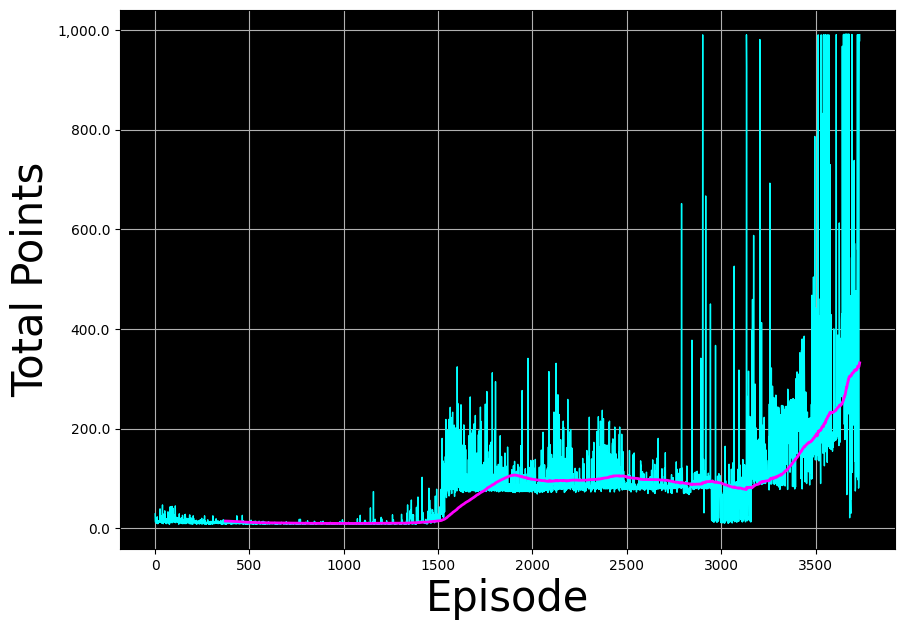

In [63]:
# Plot the total point history along with the moving average
utils.plot_history(total_point_history)

### See the Trained Agent In Action

In [65]:
env = CustomCartPoleEnv(action_cost=action_cost, render_mode='human')
state = env.reset()[0]
env.render()

In [66]:
# Try to put the carter in a bad spot at the start by executing this cell several times !
#env.step(0)

In [67]:
max_updates = 500

for _ in range(max_updates):
    state = torch.from_numpy(np.expand_dims(state, axis=0)).float()
    q_values = q_network(state)
    action = torch.argmax(q_values[0]).item()
    state, _, _, _, _ = env.step(action)

In [69]:
#env.close()